# Coronary Heart Disease Predictive Modelling in Framingham Dataset

## 1. Introduction  

The analyzed data is based on the cardiovascular study on residents of the town of Framingham, Massachusetts.  

The task is to perform an analysis and fit a logistic regression model for predicting 10-year risk factors of coronary heart disease (CHD) as well as choose the most appropriate classification metric for this problem and calculate the optimal threshold.  

### Source  

The dataset is publicly available on Kaggle: [Cardiovascular Study Dataset](https://www.kaggle.com/datasets/christofel04/cardiovascular-study-dataset-predict-heart-disea).  

### Variables  

Attributes include demographic, behavioral, and medical risk factors.
### Data Description
##### Demographic:
- **Sex**: male or female ("M" or "F") (Nominal)
- **Age**: Age of the patient (Continuous)
##### Behavioral:
- **is_smoking**: Current smoker ("Yes" or "No") (Nominal)
- **Cigs Per Day**: Average number of cigarettes smoked per day (Continuous)
##### Medical (history):
- **BP Meds**: On blood pressure medication (Nominal)
- **Prevalent Stroke**: Had a stroke before (Nominal)
- **Prevalent Hyp**: Hypertensive (Nominal)
- **Diabetes**: Had diabetes (Nominal)
##### Medical (current):
- **Tot Chol**: Total cholesterol level (Continuous)
- **Sys BP**: Systolic blood pressure (Continuous)
- **Dia BP**: Diastolic blood pressure (Continuous)
- **BMI**: Body Mass Index (Continuous)
- **Heart Rate**: Heart rate (Continuous)
- **Glucose**: Glucose level (Continuous)
##### Predict variable (desired target):
- **10-year risk of CHD**: (Binary) “1” for “Yes”, “0” for “No”

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
)
from sklearn.preprocessing import (
    FunctionTransformer,
    StandardScaler,
    OneHotEncoder,
    LabelEncoder,
)
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from scipy.stats import chi2_contingency

import warnings

warnings.filterwarnings("ignore")

## 2. Data Loading and Initial Exploration

In [2]:
df = pd.read_csv("train.csv", index_col=0)

In [3]:
df.sample(10)

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
id,,,,,,,,,,,,,,,,
3275,40,1.0,F,YES,15.0,0.0,0,0,0,199.0,122.0,82.0,22.16,85.0,77.0,0
51,56,3.0,M,YES,20.0,0.0,0,0,0,340.0,134.0,89.5,21.91,50.0,72.0,1
2439,52,3.0,M,NO,0.0,0.0,0,0,0,205.0,122.0,73.0,22.73,70.0,85.0,0
1638,51,1.0,M,YES,20.0,0.0,0,1,0,239.0,168.0,102.0,30.38,82.0,68.0,1
247,36,3.0,F,YES,15.0,0.0,0,0,0,202.0,105.5,67.0,22.66,90.0,63.0,0
3036,64,1.0,M,YES,20.0,0.0,0,0,0,214.0,116.0,77.0,22.48,72.0,71.0,0
2948,37,4.0,F,YES,3.0,0.0,0,0,0,160.0,104.0,61.0,20.22,85.0,100.0,0
1547,52,1.0,M,NO,0.0,0.0,0,0,0,285.0,135.0,86.0,27.78,88.0,93.0,0
987,56,3.0,F,NO,0.0,0.0,0,0,0,207.0,120.0,60.0,22.89,75.0,71.0,0


In [4]:
print(df.shape)

(3390, 16)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3390 entries, 0 to 3389
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              3390 non-null   int64  
 1   education        3303 non-null   float64
 2   sex              3390 non-null   object 
 3   is_smoking       3390 non-null   object 
 4   cigsPerDay       3368 non-null   float64
 5   BPMeds           3346 non-null   float64
 6   prevalentStroke  3390 non-null   int64  
 7   prevalentHyp     3390 non-null   int64  
 8   diabetes         3390 non-null   int64  
 9   totChol          3352 non-null   float64
 10  sysBP            3390 non-null   float64
 11  diaBP            3390 non-null   float64
 12  BMI              3376 non-null   float64
 13  heartRate        3389 non-null   float64
 14  glucose          3086 non-null   float64
 15  TenYearCHD       3390 non-null   int64  
dtypes: float64(9), int64(5), object(2)
memory usage: 450.2+ KB


- There are 3,390 entries and 16 columns in the dataset.

#### 2.1. Checking missing and duplicate values

In [6]:
df.isnull().sum().sort_values(ascending=False)

glucose            304
education           87
BPMeds              44
totChol             38
cigsPerDay          22
BMI                 14
heartRate            1
age                  0
prevalentHyp         0
prevalentStroke      0
sex                  0
is_smoking           0
diaBP                0
sysBP                0
diabetes             0
TenYearCHD           0
dtype: int64

In [7]:
total_rows = len(df)
null_values = df.isnull().sum()
percent_nulls = ((null_values / total_rows) * 100).round(2).sort_values(ascending=False)
percent_nulls

glucose            8.97
education          2.57
BPMeds             1.30
totChol            1.12
cigsPerDay         0.65
BMI                0.41
heartRate          0.03
age                0.00
prevalentHyp       0.00
prevalentStroke    0.00
sex                0.00
is_smoking         0.00
diaBP              0.00
sysBP              0.00
diabetes           0.00
TenYearCHD         0.00
dtype: float64

- The variable with the most missing values is glucose (304, or 8.97% missing entries), followed by education (87, or 2.57%), BPMeds (44, or 1.30%), totChol (38, or 1.12%), cigsPerDay (22, or 0.65%), BMI (14, or 0.41%), and heartRate (1, or 0.03%). This indicates a significant amount of incomplete data in the dataset that may need addressing.
- Other variables have 0 missing values.

In [8]:
duplicate_count = df.duplicated().sum()
print(duplicate_count)

0


- There are no duplicate values in the dataset.

#### 2.2. Descriptive statistics

In [9]:
continuous_variables = [
    "age",
    "cigsPerDay",
    "totChol",
    "sysBP",
    "diaBP",
    "BMI",
    "heartRate",
    "glucose",
]
df[continuous_variables].describe().T

,count,mean,std,min,25%,50%,75%,max
age,3390.0,49.542183,8.592878,32.00,42.00,49.00,56.00,70.0
cigsPerDay,3368.0,9.069477,11.879078,0.00,0.00,0.00,20.00,70.0
totChol,3352.0,237.074284,45.247430,107.00,206.00,234.00,264.00,696.0
sysBP,3390.0,132.601180,22.292030,83.50,117.00,128.50,144.00,295.0
diaBP,3390.0,82.883038,12.023581,48.00,74.50,82.00,90.00,142.5
BMI,3376.0,25.794964,4.115449,15.96,23.02,25.38,28.04,56.8
heartRate,3389.0,75.977279,11.971868,45.00,68.00,75.00,83.00,143.0
glucose,3086.0,82.086520,24.244753,40.00,71.00,78.00,87.00,394.0


### Key Insights:
1. **Age Distribution**: The age of participants ranges from 32 to 70 years, with a mean age of ~ 49 years and the majority in the middle age group (from 42 to 56 years).

2. **Smoking Habits (CigsPerDay)**: A significant portion of participants do not smoke (median - 0 cigarettes per day), however, some smoke up to 70 cigarettes per day.

3. **Cholesterol Levels (TotChol)**: The total cholesterol levels range widely, from 107 to 696 mg/dL. The mean cholesterol level is ~ 237 mg/dL and the 75th percentile is 264 mg/dL, indicating that a substantial portion of the population may have higher-than-average cholesterol levels, and some upper values are really extreme.

4. **Blood Pressure (SysBP and DiaBP)**: Both systolic and diastolic blood pressure show variability. The mean systolic blood pressure is ~ 132 mmHg, which is slightly elevated, suggesting the presence of hypertension in the population. The mean diastolic blood pressure is ~ 82 mmHg, which is at the upper range of normal.

5. **Body Mass Index (BMI)**: The BMI values range from ~ 15 to ~ 56, with a mean of ~ 25 and the 75th percentile of ~ 28 suggests that a significant portion of the population may be overweight or obese.

6. **Heart Rate**: The range is from 45 to 143 bpm. While the mean heart rate of ~ 76 bpm is within normal limits, the upper range suggests some individuals may have tachycardia.

7. **Glucose Levels**: The glucose levels have a wide range, with a mean of ~ 82 mg/dL. The max value of 394 mg/dL indicates that some individuals may have uncontrolled diabetes.

##### Official Reference Values*  
**Sources: American Heart Association: "Understanding Blood Pressure Readings," "Cholesterol Levels: What You Need to Know," "BMI Calculator," and "What Is a Normal Resting Heart Rate?"; Centers for Disease Control and Prevention: "Health Effects of Cigarette Smoking."; American Diabetes Association: "Standards of Medical Care in Diabetes—2023."*
- **CigsPerDay**: **Non-smokers**: 0 cigarettes/day; **Heavy smokers**: >20 cigarettes/day

- **Total Cholesterol (TotChol)**: **Desirable**: <200 mg/dL; **Borderline high**: 200-239 mg/dL; **High**: ≥240 mg/dL

- **Systolic Blood Pressure (SysBP)**: **Normal**: <120 mmHg; **Elevated**: 120-129 mmHg; **Hypertension Stage 1**: 130-139 mmHg; **Hypertension Stage 2**: ≥140 mmHg

- **Diastolic Blood Pressure (DiaBP)**: **Normal**: <80 mmHg; **Elevated**: 80-89 mmHg; **Hypertension Stage 1**: 90-99 mmHg; **Hypertension Stage 2**: ≥100 mmHg

- **Body Mass Index (BMI)**: **Underweight**: <18.5; **Normal weight**: 18.5-24.9; **Overweight**: 25-29.9; **Obesity**: ≥30

- **Heart Rate**: **Normal**: 60-100 beats per minute (bpm); **Tachycardia**: >100 bpm

- **Glucose**: **Normal**: 70-99 mg/dL; **Prediabetes**: 100-125 mg/dL; **Diabetes**: ≥126 mg/dL

#### 2.3. Converting categorical variables to numeric

In [10]:
df["sex"] = df["sex"].map({"F": 0, "M": 1})
df["is_smoking"] = df["is_smoking"].map({"NO": 0, "YES": 1})

## 3. Exploratory Data Analysis

#### 3.1. Distribution of continuous variables in relation to 10-Year Coronary Heart Disease

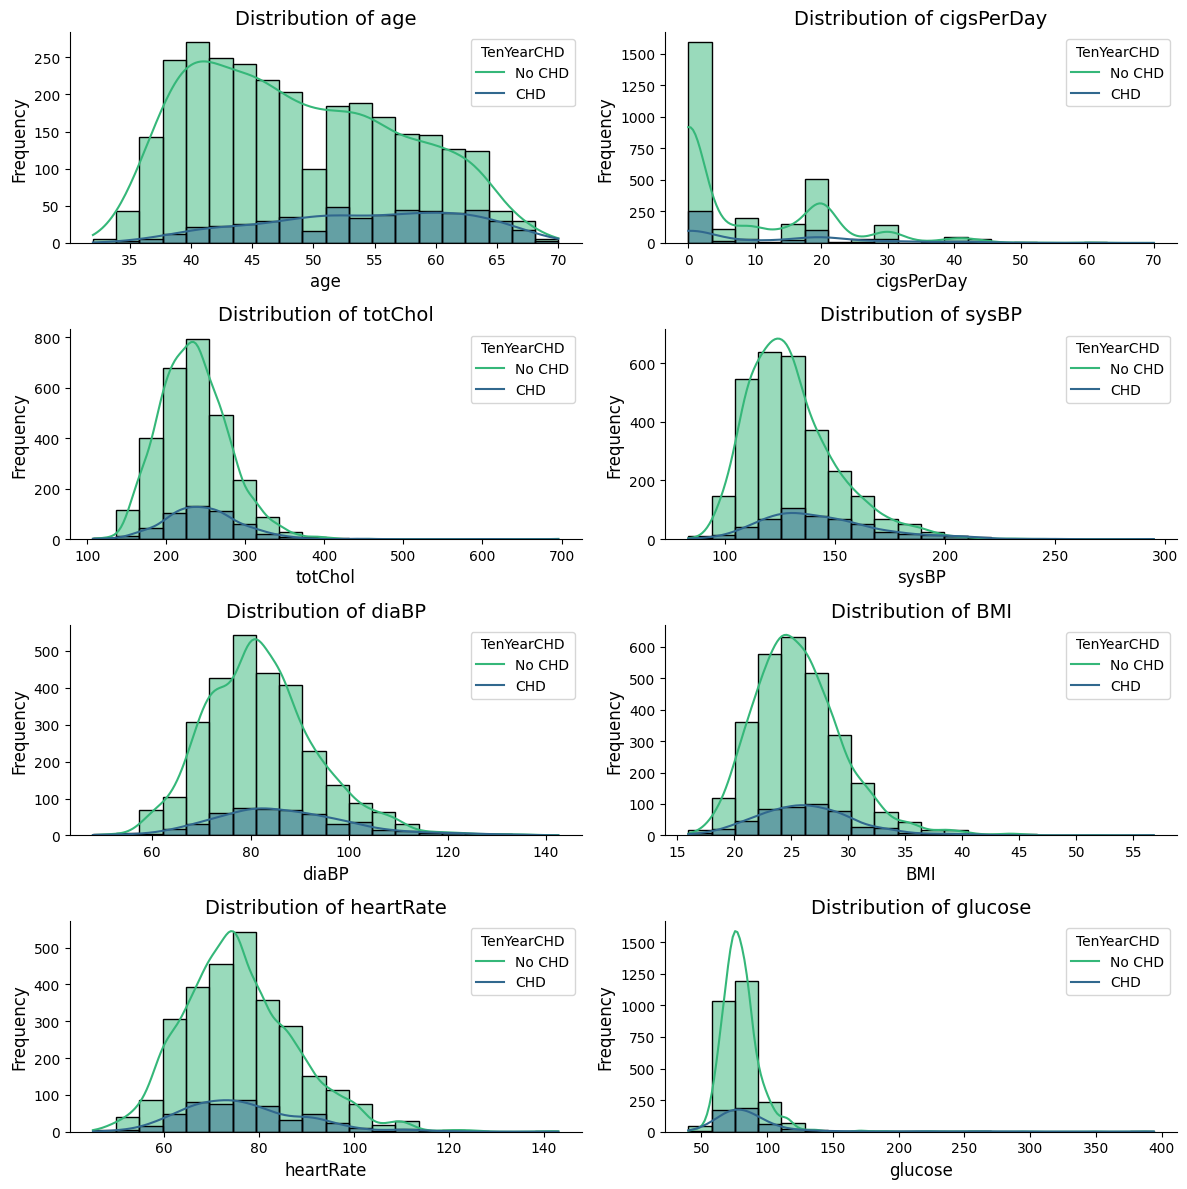

In [11]:
continuous_cols = [
    "age",
    "cigsPerDay",
    "totChol",
    "sysBP",
    "diaBP",
    "BMI",
    "heartRate",
    "glucose",
]

df["TenYearCHD_Label"] = df["TenYearCHD"].map({0: "0", 1: "1"})

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 12))
axes = axes.flatten()

for i, col in enumerate(continuous_cols):
    sns.histplot(
        data=df,
        x=col,
        bins=20,
        ax=axes[i],
        kde=True,
        hue="TenYearCHD_Label",
        palette="viridis",
    )

    axes[i].set_title(f"Distribution of {col}", fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel("Frequency", fontsize=12)
    axes[i].grid(False)

    legend = axes[i].legend(title="TenYearCHD", labels=["No CHD", "CHD"])

    axes[i].spines["top"].set_visible(False)
    axes[i].spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

#### Observations:
- The chart displays the distribution of each continuous variable across the dataset and clearly shows that the dataset contains more cases of patients without CHD.
- Also, the chart does not tell whether the observed differences between the CHD groups are statistically significant: while visual differences might suggest a potential relationship, they do not quantify it. Therefore, in the next step they are complimented by a box plot, which also allows to make more informed decisions about variable selection for the logistic regression model.
- The **potential relationships between continuous variables and the risk of CHD**:
- **Age**: CHD risk tends to increases with age, with a more pronounced difference after 50.
- **Cigarettes Per Day**: Non-smokers are more common in the dataset; smokers have a slightly higher proportion of CHD cases.
- **Total Cholesterol**: Higher cholesterol levels may potentially be associated with increased CHD risk.
- **Systolic Blood Pressure** and **Diastolic Blood Pressure**: Higher systolic and diastolic BP seem to correlate with increased CHD risk.
- **BMI**: Slight increase in CHD risk with higher BMI.
- **Heart Rate**: small difference in distribution between CHD and non-CHD groups.
- **Glucose**: Higher glucose levels are potentially associated with increased CHD risk.
- Overall, **age, smoking, cholesterol, blood pressure, and glucose levels appear to have the strongest relation with** CHD risk in this dataset.

#### 3.2. Distribution of categorical variables in relation to 10-Year Coronary Heart Disease

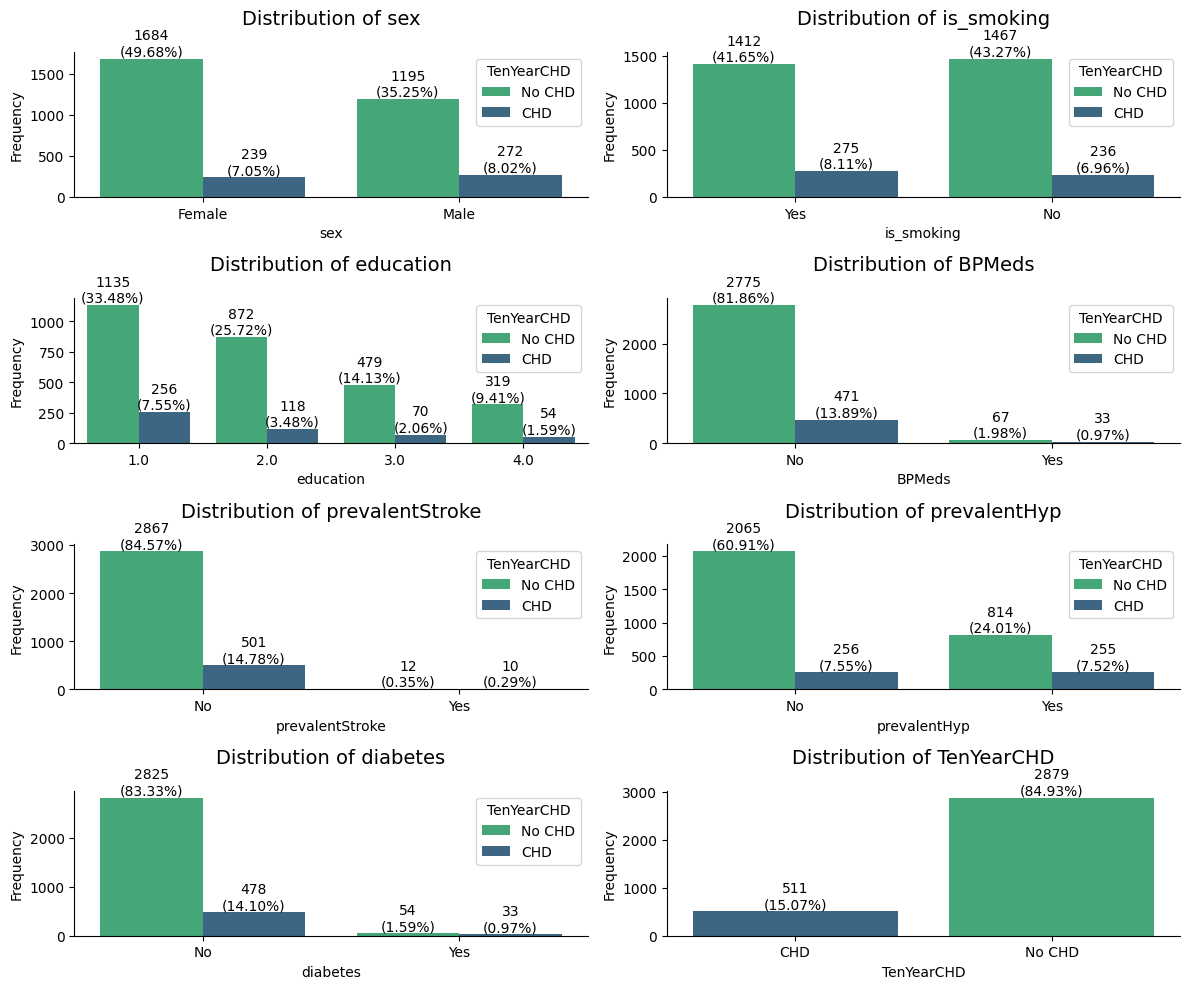

In [12]:
categorical_cols = [
    "sex",
    "is_smoking",
    "education",
    "BPMeds",
    "prevalentStroke",
    "prevalentHyp",
    "diabetes",
    "TenYearCHD",
]

label_mapping = {
    "sex": {0: "Female", 1: "Male"},
    "is_smoking": {0: "No", 1: "Yes"},
    "BPMeds": {0: "No", 1: "Yes"},
    "prevalentStroke": {0: "No", 1: "Yes"},
    "prevalentHyp": {0: "No", 1: "Yes"},
    "diabetes": {0: "No", 1: "Yes"},
    "TenYearCHD": {0: "No CHD", 1: "CHD"},
}

for col, mapping in label_mapping.items():
    df[col] = df[col].map(mapping)

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    if col in df.columns:
        plot = sns.countplot(
            data=df,
            x=col,
            hue="TenYearCHD",
            hue_order=["No CHD", "CHD"],
            ax=axes[i],
            palette=sns.color_palette("viridis", 2)[::-1],
        )
        axes[i].set_title(f"Distribution of {col}", fontsize=14, pad=20)
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Frequency")
        axes[i].grid(False)

        total = len(df[col])
        for container in axes[i].containers:
            values = [v.get_height() for v in container]
            labels = [f"{v:.0f}\n({v/total:.2%})" for v in values]
            axes[i].bar_label(container, labels=labels, label_type="edge")

        axes[i].spines["top"].set_visible(False)
        axes[i].spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

#### Observations:
- **Sex**: Despite fewer males than females in the dataset, males have a greater proportion of CHD cases.
- **Smoking Status**: Smokers have a slightly higher proportion of CHD cases compared to non-smokers, but the difference is not substantial. 
- **Education Level**: Presumably lower education level (1.0) is associated with a higher number of CHD cases. Presumably higher education levels (2.0, 3.0 and 4.0) show a slightly reduced proportion of CHD cases.
- **Blood Pressure Medication**: Individuals on blood pressure medication are fewer in number and they have a higher proportion of CHD cases.
- **Prevalent Stroke**: A history of stroke significantly increases the likelihood of CHD.
- **Prevalent Hypertension**: Hypertensive individuals have a higher proportion of CHD cases compared to non-hypertensive individuals.
- **Diabetes**: Although the number of diabetic patients is much lower, the proportion of those with CHD is notably higher, which shows a strong association with CHD.
- **CHD Distribution**: The dataset is imbalanced, with a larger proportion of individuals not developing CHD within ten years. This imbalance should be considered when modeling to avoid biased predictions.
- Overall, **sex (notably, male), blood pressure medication, prevalent stroke and hypertension, as well as diabetes appear to be the strongest indicators** of CHD risk in this dataset.

#### 3.3. Boxplots of continuous variables in relation to 10-Year Coronary Heart Disease
- To get a more comprehensive understanding of how the continuous variables relate to CHD risk, they are also shown in box plots, which provide further insights into statistical properties of the dataset and allow to explore and prove the trends observed in the distributions.
- The box plots also clearly highlight possible outliers in the data. 

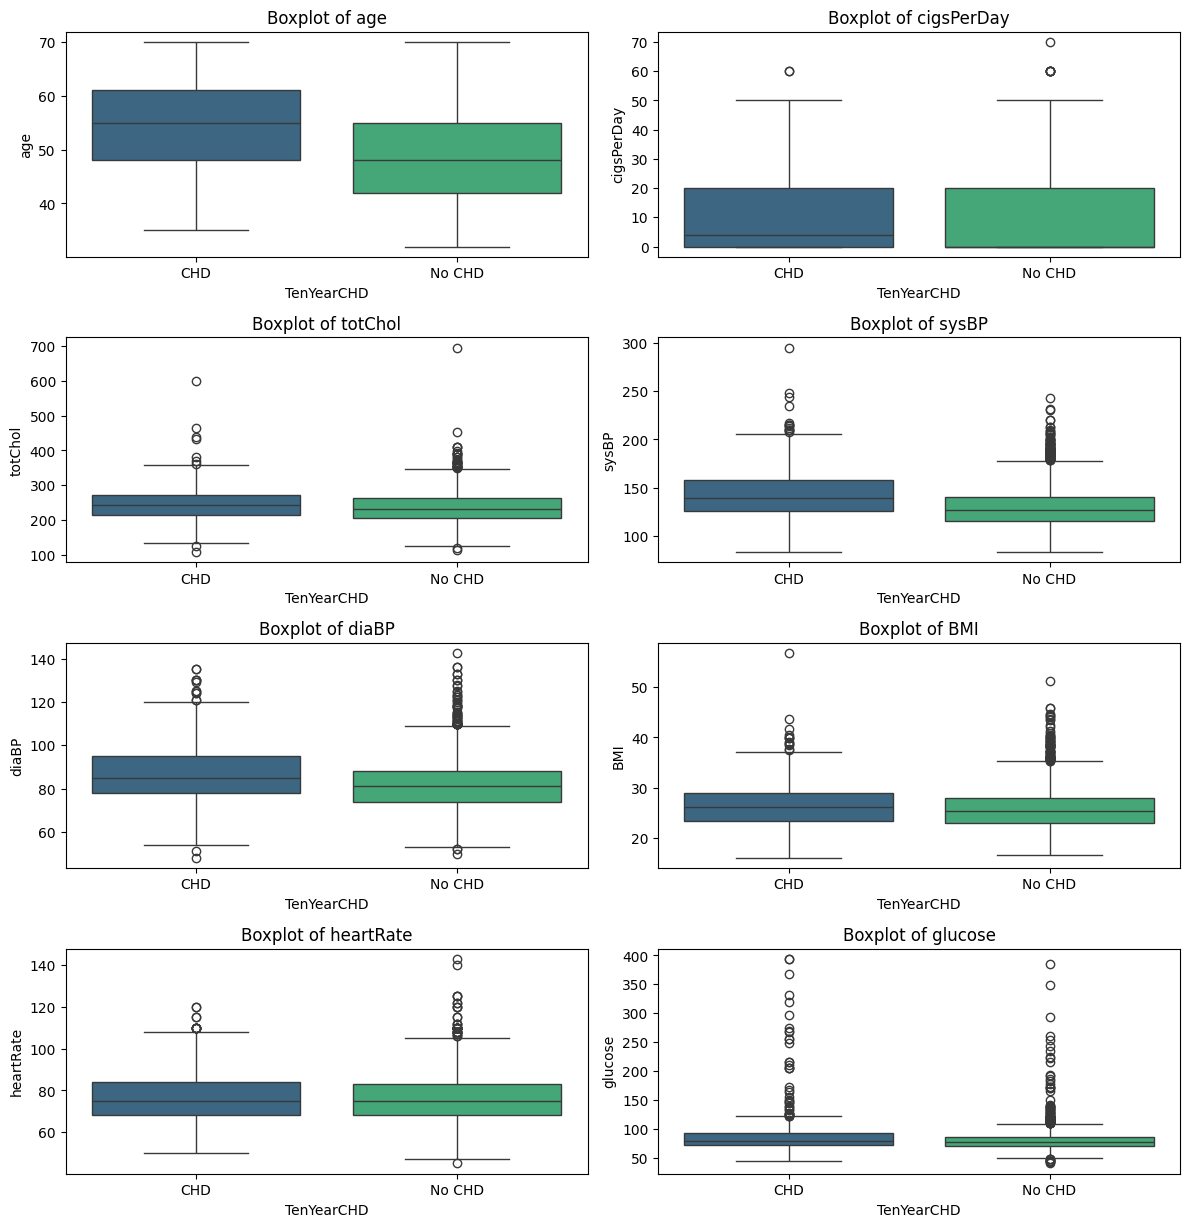

In [13]:
plt.figure(figsize=(12, 15))

for i, col in enumerate(continuous_cols):
    plt.subplot(len(continuous_cols) // 2 + 1, 2, i + 1)
    sns.boxplot(x="TenYearCHD", y=col, data=df, palette="viridis")
    plt.title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()

#### Observations: 
- **Age**: Individuals with CHD tend to be older on average compared to those without CHD. Age can potentially be a notable factor for CHD.
- **Cigarettes Per Day**: There is slight difference between CHD and non-CHD groups based on the number of cigarettes smoked per day. This suggests that although the smoking quantity alone may not be a strong predictor in this dataset, it has an effect on CHD risk.
- **Total Cholesterol**: The CHD group tends to have slightly higher total cholesterol levels compared to the non-CHD group, though the difference is not pronounced. Some outliers with extremely high cholesterol levels exist in both groups.
- **Systolic Blood Pressure**: CHD group generally has higher systolic BP, with a broader range and higher outlier values compared to the non-CHD group. Elevated systolic BP can potentially be a risk factor for CHD.
- **Diastolic Blood Pressure**: Similar to systolic BP, individuals with CHD tend to have higher diastolic blood pressure, although the difference is less pronounced.
- **Body Mass Index**: The distribution of BMI is similar between those with and without CHD, indicating BMI might not be a strong differentiator for CHD risk in this dataset.
- **Heart Rate**: Heart rate distributions between the CHD and non-CHD groups are nearly identical, suggesting heart rate alone isn't a significant factor in predicting CHD in this dataset.
- **Glucose**: Individuals with CHD tend to have slightly higher glucose levels, with more outliers in the CHD group. Elevated glucose levels may contribute to CHD risk.
- Overall, box plots confirm the observations made from distributions of continuous features: **age, smoking, cholesterol, blood pressure, and glucose levels appear to have the strongest relation** to CHD risk in this dataset.

#### 3.4. Correlation matrix of all variables

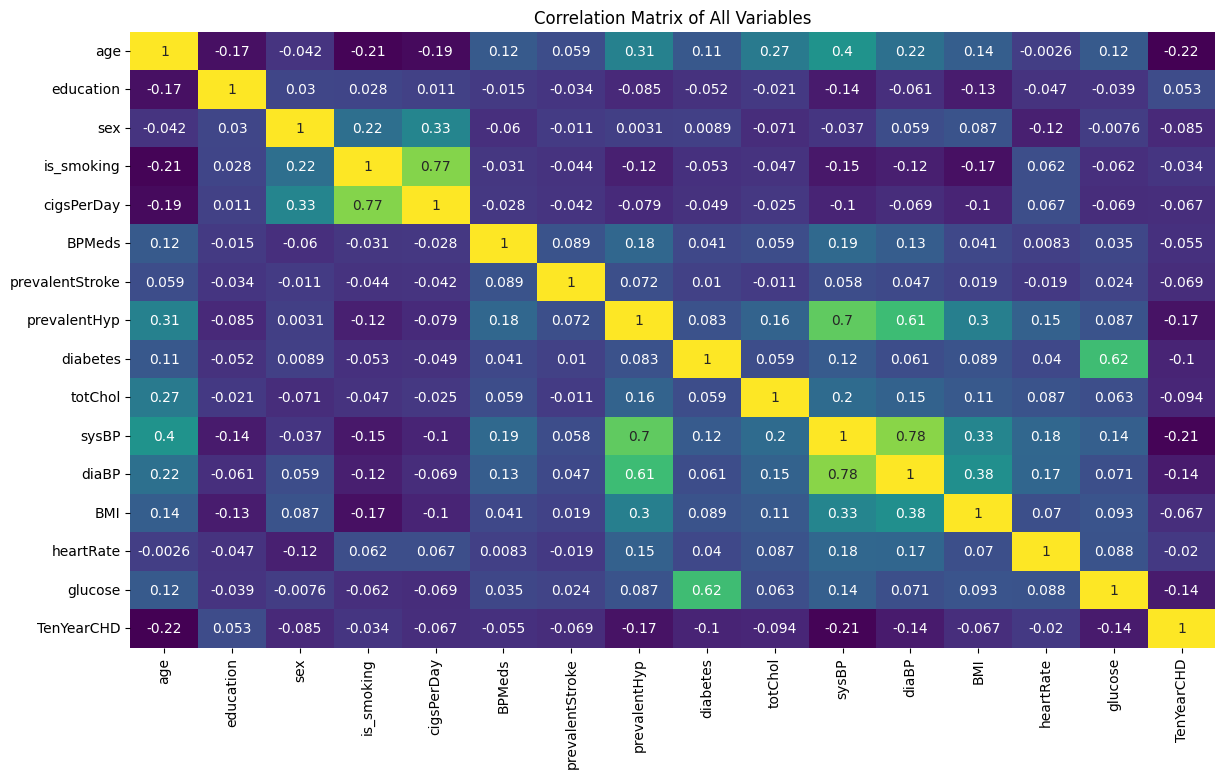

In [14]:
label_encoder = LabelEncoder()

target_column = "TenYearCHD_Label"

for column in df.select_dtypes(include=["object"]).columns:
    if column != target_column:
        df[column] = label_encoder.fit_transform(df[column])

df_without_label = df.drop(columns=[target_column], errors="ignore")

corr_matrix = df_without_label.corr()

plt.figure(figsize=(14, 8))
sns.heatmap(corr_matrix, annot=True, cmap="viridis", cbar=False)
plt.title("Correlation Matrix of All Variables")
plt.show()

#### Observations:
- In this correlation matrix, the following metrics was used to assess the multicollinearity and correlation strength between variables (multicollinearity occurs when two or more predictors in a regression model are highly correlated, leading to unreliable estimates and inflated standard errors):
- **Correlation Strength:**
    - |r| < 0.2: Weak correlation
    - 0.2 ≤ |r| < 0.4: Moderate correlation
    - 0.4 ≤ |r| < 0.7: Strong correlation
    - |r| ≥ 0.7: Very strong correlation (potential multicollinearity) between variables, which can negatively impact the model's performance and interpretability and lead to overfitting, making the model less generalizable to new data. It can also complicate the interpretation of the model, as it becomes difficult to determine the individual effect of correlated predictors.
- Instances of potential **multicollinearity** in the dataset:
- **is_smoking and cigsPerDay** (0.77)
- **sysBP and diaBP** (0.78)
- **sysBP and prevalentHyp** (0.7)
- **Potentially Useful Predictors for the Model** (showing the strongest linear relationship with the target variable):
- **age** (0.22)
- **sysBP** (0.21)
- These cases of possible multicollinearity may be reasoned by logic as well (**sysBP** and **diaBP** tend to be related, as well as **sysBP** and **prevalentHyp**. Similarly, only **is_smoking** people smoke > 0 cigarettes per day). 
- One of the ways to address multicollinearity is to remove the highly correlated variables from model building to avoid issues with model stability and interpretability, therefore, a decision was made to use **sysBP** (usually related to heart activity) and **cigsPerDay** in feature selection. **prevalentHyp** will be further checked in the following steps of the EDA.
- Also, **age** and **sysBP** should be considered for inclusion in feature selection as potentially useful predictors for the model.

#### 3.5. Chi-square tests for categorical variables

-  Chi-square tests will be used to identify the association between categorical variables and the target variable

In [15]:
categorical_vars = [
    "is_smoking",
    "sex",
    "BPMeds",
    "education",
    "prevalentStroke",
    "diabetes",
    "prevalentHyp",
]

target_var = "TenYearCHD"


def chi_square_test(df, var, target_var):
    """
    Perform a Chi-square test of independence between a categorical variable and a target variable.

    This function computes the Chi-square statistic, p-value, degrees of freedom,
    and expected frequencies for the given categorical variable and target variable
    from the provided DataFrame. It prints the results of the Chi-square test.

    Parameters:
    ----------
    df : pandas.DataFrame
        The DataFrame containing the data for analysis. It should include the specified
        categorical variable and the target variable.

    var : str
        The name of the categorical variable to be tested. This variable should be present
        in the DataFrame.

    target_var : str
        The name of the target variable to be tested against. This variable should also be
        present in the DataFrame.

    Returns:
    -------
    None
        The function prints the Chi-square statistic, p-value, degrees of freedom,
        and expected frequencies to the console.
    """
    contingency_table = pd.crosstab(df[var], df[target_var])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"\nChi-square Test between {var} and {target_var}")
    print(f"Chi2 Statistic: {chi2}")
    print(f"P-Value: {p}")
    print(f"Degrees of Freedom: {dof}")


for var in categorical_vars:
    chi_square_test(df, var, target_var)


Chi-square Test between is_smoking and TenYearCHD
Chi2 Statistic: 3.7632509937955985
P-Value: 0.05239062274853224
Degrees of Freedom: 1

Chi-square Test between sex and TenYearCHD
Chi2 Statistic: 23.81436391559416
P-Value: 1.060878293561796e-06
Degrees of Freedom: 1

Chi-square Test between BPMeds and TenYearCHD
Chi2 Statistic: 25.931794027618302
P-Value: 2.3387428564135407e-06
Degrees of Freedom: 2

Chi-square Test between education and TenYearCHD
Chi2 Statistic: 22.16105229004903
P-Value: 6.0386467492345515e-05
Degrees of Freedom: 3

Chi-square Test between prevalentStroke and TenYearCHD
Chi2 Statistic: 13.66624613244209
P-Value: 0.0002183439934300791
Degrees of Freedom: 1

Chi-square Test between diabetes and TenYearCHD
Chi2 Statistic: 34.63203270914867
P-Value: 3.982978687382329e-09
Degrees of Freedom: 1

Chi-square Test between prevalentHyp and TenYearCHD
Chi2 Statistic: 93.02951112773958
P-Value: 5.152036591565972e-22
Degrees of Freedom: 1


#### Observations: 
- A small **p-value** (typically ≤ 0.05) suggests that there is an association between the categorical variable and the target.
- The higher the **chi-square statistic**, the greater the association between the variable and the target.
- **Strong associations (based on low p-values and high chi-square statistics)**:
- **Sex**: There's a significant association between sex and the target variable.
- **BPMeds**: Use of blood pressure medications is significantly associated with the target.
- **Education**: The level of education is significantly associated with the target.
- **PrevalentStroke**: History of stroke is significantly associated with the target.
- **Diabetes**: Presence of diabetes shows a very strong association with the target.
- **PrevalentHyp**: History of hypertension is strongly associated with the target.
- **Weak association (based on slightly higher p-value (0.052) and low chi-square statistics (3.76))**:
- **Is_smoking**: The relationship between smoking status and the outcome is not significant. 
- Interestingly, chi-square tests show that **education** may also have an effect on CHD.
- Overall, chi-square tests confirmed the outcome of categorical distributions: **sex, blood pressure medication, prevalent stroke and hypertension, as well as diabetes** seem to be the strongest indicators of CHD risk in ten-years. 

#### 3.6. Calculation of Variance Inflation Factor (VIF) 

In [16]:
numerical_cols = df.select_dtypes(include=["float64", "int64"]).columns
categorical_cols = df.select_dtypes(include=["object", "category", "bool"]).columns

numerical_imputer = SimpleImputer(strategy="median")
categorical_imputer = SimpleImputer(strategy="most_frequent")

df_num_imputed = pd.DataFrame(
    numerical_imputer.fit_transform(df[numerical_cols]),
    columns=numerical_cols,
    index=df.index,
)
df_cat_imputed = pd.DataFrame(
    categorical_imputer.fit_transform(df[categorical_cols]),
    columns=categorical_cols,
    index=df.index,
)

scaler = StandardScaler()
df_num_standardized = pd.DataFrame(
    scaler.fit_transform(df_num_imputed), columns=numerical_cols, index=df.index
)

vif_data = pd.DataFrame()
vif_data["Variable"] = df_num_standardized.columns
vif_data["VIF"] = [
    variance_inflation_factor(df_num_standardized.values, i)
    for i in range(df_num_standardized.shape[1])
]

vif_data_sorted = vif_data.sort_values("VIF", ascending=False).reset_index(drop=True)

print(vif_data_sorted)

           Variable       VIF
0             sysBP  3.763098
1             diaBP  2.911228
2        cigsPerDay  2.613326
3        is_smoking  2.481741
4      prevalentHyp  2.039383
5           glucose  1.626468
6          diabetes  1.603114
7               age  1.409137
8               BMI  1.239502
9               sex  1.214237
10          totChol  1.112149
11       TenYearCHD  1.111847
12        heartRate  1.090801
13        education  1.057929
14           BPMeds  1.055932
15  prevalentStroke  1.019278


#### Observations: 
- VIF = 1: No correlation;
1 < VIF < 5: Moderate correlation;
5 ≤ VIF < 10: High correlation;
VIF ≥ 10: Very high correlation

- All VIF values are below 5, indicating no severe multicollinearity issues
- **Highest VIF Values**:

- **sysBP (3.76)**: Highest VIF, suggesting some correlation with other variables; **diaBP (2.91)**: Second highest, likely correlated with **sysBP**
- **cigsPerDay (2.61)** and **is_smoking (2.48)**: Close VIF values suggest they might be capturing similar information
- **prevalentHyp (2.04)** is likely correlated with **sysBP**

- **Lowest VIF Values**:
- **prevalentStroke (1.02)**, **BPMeds (1.06)**, and **education (1.06)**: Show very low correlation with other variables

- **Target Variable**: **TenYearCHD (1.11)**: Low VIF suggests it's not strongly predicted by a linear combination of other variables

- **glucose (1.63)** and **diabetes (1.60)**: Similar VIF values might indicate they capture related but not identical information
- **age (1.41)**, **BMI (1.24)**, **sex (1.21)**, **totChol (1.11)**, **heartRate (1.09)**: Relatively low VIF values suggest they are not strongly correlated with other variables

#### 3.7. Conclusions on Exploratory Data Analysis:
1. **Distribution of CHD Cases**: The dataset is imbalanced, with significantly larger number of non-CHD cases compared to CHD cases. This imbalance should be addressed in modeling to avoid biased predictions.
2. **Presence of Outliers and Missing Values**: The dataset contains high number of outliers and missing values that need handling.
3. **Feature Selection**: 
    - Based on detailed analysis of continuous and categorical variables and their relation with the target variable, **age, blood pressure (systolic), cholesterol, and glucose levels** are identified as the strongest predictors of CHD risk and might be prioritized in the logistic regression model. 
    - Furthermore,  **cigsPerDay, sex, BP meds, education, diabetes, prevalent stroke and hypertension** were also identified as potential predictors and will be used in building logistic regression model. 
    - To improve model stability and address possible multicollinearity, highly correlated variables (**diaBP** and **is_smoking**) will not be used in modelling. 
5. **Modelling Strategy**: Given the highly imbalanced dataset, techniques such as stratification will be employed to ensure robust model performance. Stratifying helps to avoid situations where one set (training or testing) has a disproportionately high or low representation of one class, which can lead to biased model performance evaluation. 
6. **Further Analysis**: The insights gained from Exploratory Data Analysis will guide the feature selection process and inform the development of a predictive model for CHD risk.
7. **Next steps** will involve splitting the dataset into training and test sets; handling outliers and null values in the training dataset, building pipelines, model training and validation to assess performance.

## 4. Modelling
- In this part, the following steps will be performed:
- The dataset will be split into training and test datasets.
- Outliers and missing data will be addressed.
- Features to be included in the logistic regression model will be selected.
- Pipelines will be built and used in the logistic regression model.
- The most appropriate classification metric will be chosen and optimal threshold calculated. 
- Key model accuracy metrics will be identified and their interpretation given.

#### 4.1. Splitting the data into training and test datasets

In [17]:
df["TenYearCHD"] = df["TenYearCHD"].map({1: 0, 0: 1})
X = df.drop("TenYearCHD", axis=1)
y = df["TenYearCHD"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training dataset size: {X_train.shape}")
print(f"Test dataset size: {X_test.shape}")

Training dataset size: (2712, 16)
Test dataset size: (678, 16)


#### 4.2. Identifying and handling outliers and missing values

##### 4.2.1. Strategy for handling outliers
- As most of distributions of the continuous features in this dataset are skewed, **Interquartile Range (IQR) method** will be used to identify and treat outliers. The use of this method in imbalanced datasets is justified due to its robustness against skewed distributions and its ability to effectively identify extreme values without being influenced by the overall distribution shape. The IQR method focuses on the middle 50% of the data, making it less sensitive to extreme values compared to methods like Z-scores, which assume a normal distribution.
- The **3 * IQR threshold** was chosen over the standard 1.5 * IQR, as the former captures more extreme outliers compared to the 1.5 * IQR threshold. By using a higher multiplier, the method helps ensure that only the most significant deviations from the central tendency are flagged as outliers, and in the context of the Framingham dataset it might be useful as some really extreme values may be real to some study participants.
- The dataset is small, therefore, the outliers will not be removed, but rather replaced by the corresponding lower or upper bound values based on the 3 * IQR rule.
- Clipping outliers, as opposed to, e.g., applying a log transformation, is preferred here because it maintains the original data distribution while limiting the influence of extreme values and preserving the overall structure of the dataset. This approach is particularly useful when the dataset contains meaningful extreme values that should not be discarded entirely, as capping allows for their inclusion without letting them to disproportionately affect the model training.

##### 4.2.2. Strategy for handling missing values
- For **numerical features**, Simple Imputer will be used, imputing median where null is found
- For **categorical features**, Simple Imputer will be used, imputing mode where null is found

In [18]:
training_nulls = X_train.isnull().sum()
training_nulls_percentage = (
    ((training_nulls / len(X_train)) * 100).round(2).sort_values(ascending=False)
)
training_nulls_percentage

glucose             9.07
education           2.54
totChol             1.03
cigsPerDay          0.59
BMI                 0.48
heartRate           0.04
sex                 0.00
age                 0.00
prevalentHyp        0.00
prevalentStroke     0.00
BPMeds              0.00
is_smoking          0.00
diaBP               0.00
sysBP               0.00
diabetes            0.00
TenYearCHD_Label    0.00
dtype: float64

In [19]:
test_nulls = X_test.isnull().sum()
test_nulls_percentage = (
    ((test_nulls / len(X_test)) * 100).round(2).sort_values(ascending=False)
)
test_nulls_percentage

glucose             8.55
education           2.65
totChol             1.47
cigsPerDay          0.88
BMI                 0.15
is_smoking          0.00
sex                 0.00
age                 0.00
prevalentHyp        0.00
prevalentStroke     0.00
BPMeds              0.00
diabetes            0.00
diaBP               0.00
sysBP               0.00
heartRate           0.00
TenYearCHD_Label    0.00
dtype: float64

#### 4.3. Modelling

##### 4.3.1. Selection of features for modelling

- The following features were selected for model building based on Exploratory Data Analysis: 

In [20]:
continuous_cols = [
    "age",
    "cigsPerDay",
    "totChol",
    "sysBP",
    "glucose",
]
categorical_cols = [
    "sex",
    "BPMeds",
    "prevalentStroke",
    "prevalentHyp",
    "education",
    "diabetes",
]

##### 4.3.2. Model building

In [21]:
class OutlierTransformer:
    """
    Custom transformer for handling outliers in numerical data.
    Clips values based on the 3 * IQR rule for specified columns.
    """

    def __init__(self, columns_to_check):
        self.columns_to_check = columns_to_check
        self.lower_bounds_ = None
        self.upper_bounds_ = None

    def fit(self, X, y=None):
        """Compute the lower and upper bounds for outlier handling."""
        self.lower_bounds_ = {}
        self.upper_bounds_ = {}
        for col in self.columns_to_check:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            self.lower_bounds_[col] = Q1 - 3 * IQR
            self.upper_bounds_[col] = Q3 + 3 * IQR
        return self

    def transform(self, X):
        """Apply the outlier handling strategy to the input samples."""
        X_copy = X.copy()
        for col in self.columns_to_check:
            lower_bound = self.lower_bounds_.get(col, -np.inf)
            upper_bound = self.upper_bounds_.get(col, np.inf)
            X_copy[col] = X_copy[col].clip(lower_bound, upper_bound)
        return X_copy

    def fit_transform(self, X, y=None):
        """Fit to data, then transform it."""
        return self.fit(X, y).transform(X)


columns_to_check = [
    "age",
    "cigsPerDay",
    "totChol",
    "sysBP",
    "glucose",
]

numerical_transformer = Pipeline(
    [
        ("outlier_transformer", OutlierTransformer(columns_to_check=columns_to_check)),
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(drop="first", sparse_output=False)),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, continuous_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

model = LogisticRegression(max_iter=10000, class_weight="balanced", random_state=42)

my_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

my_pipeline.fit(X_train, y_train)

pred_probs = my_pipeline.predict_proba(X_test)[:, 1]
preds = my_pipeline.predict(X_test)

print(f"\nConfusion Matrix at Default Threshold:\n{confusion_matrix(y_test, preds)}")

report_df = (
    pd.DataFrame(classification_report(y_test, preds, output_dict=True))
    .transpose()
    .round(2)
)
print("\nClassification Report (Default Threshold):\n", report_df)
print(f"ROC-AUC: {roc_auc_score(y_test, pred_probs):.4f}")

fpr, tpr, thresholds = roc_curve(y_test, pred_probs)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"\nOptimal Threshold: {optimal_threshold:.4f}")

preds_optimal = (pred_probs >= optimal_threshold).astype(int)
print(
    f"\nConfusion Matrix at Optimal Threshold:\n{confusion_matrix(y_test, preds_optimal)}"
)
report_df_optimal = (
    pd.DataFrame(classification_report(y_test, preds_optimal, output_dict=True))
    .transpose()
    .round(2)
)
print("\nClassification Report (Optimal Threshold):\n", report_df_optimal)


Confusion Matrix at Default Threshold:
[[410 166]
 [ 36  66]]

Classification Report (Default Threshold):
               precision  recall  f1-score  support
0                  0.92    0.71      0.80    576.0
1                  0.28    0.65      0.40    102.0
accuracy           0.70    0.70      0.70      0.7
macro avg          0.60    0.68      0.60    678.0
weighted avg       0.82    0.70      0.74    678.0
ROC-AUC: 0.7206

Optimal Threshold: 0.4833

Confusion Matrix at Optimal Threshold:
[[398 178]
 [ 30  72]]

Classification Report (Optimal Threshold):
               precision  recall  f1-score  support
0                  0.93    0.69      0.79   576.00
1                  0.29    0.71      0.41   102.00
accuracy           0.69    0.69      0.69     0.69
macro avg          0.61    0.70      0.60   678.00
weighted avg       0.83    0.69      0.74   678.00


#### 4.4. Confusion Matrix at Optimal Threshold, ROC Curve, and Precision-Recall Curve

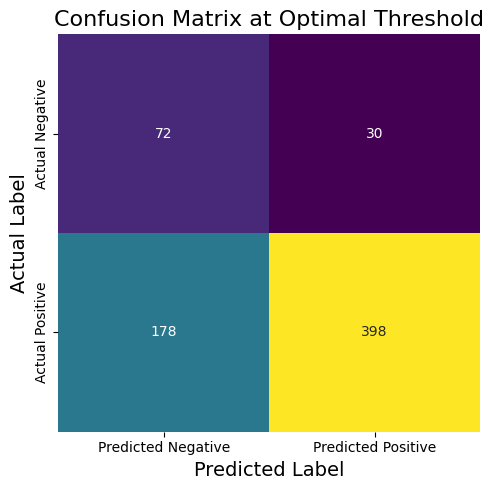

ROC-AUC: 0.7206


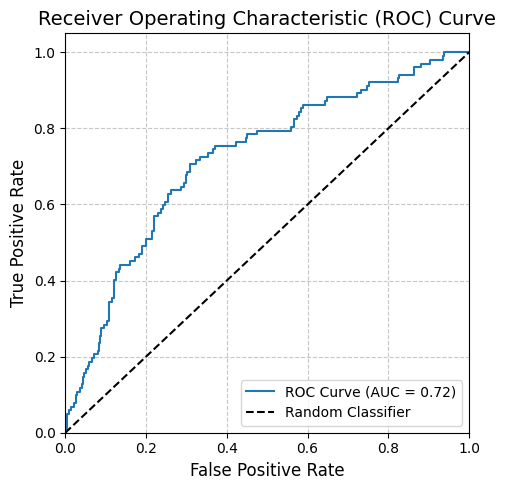

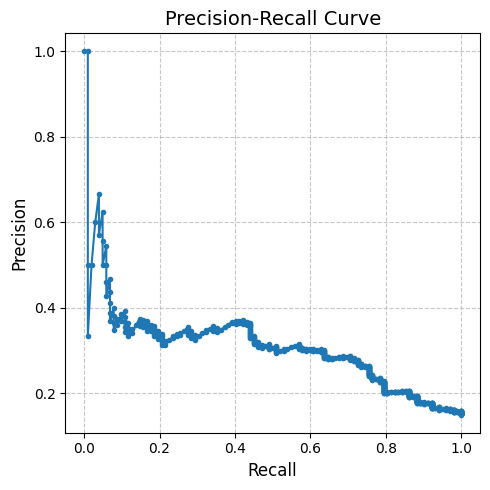

In [22]:
def calculate_optimal_threshold(y_test, pred_probs):
    """
    Calculate the optimal classification threshold that maximizes the difference between
    true positive rate (sensitivity) and false positive rate (1 - specificity).

    The optimal threshold is found by analyzing the ROC curve and selecting the threshold
    where the difference between the true positive rate (TPR) and the false positive rate (FPR) is the highest.

    Parameters:
    -----------
    y_test : array-like, shape (n_samples,)
        True binary labels for the test data. Must be 0 or 1.

    pred_probs : array-like, shape (n_samples,)
        Predicted probabilities for the positive class (typically output of a logistic regression model).

    Returns:
    --------
    float
        The optimal threshold value that maximizes the difference between the true positive rate and
        the false positive rate on the ROC curve.

    """
    fpr, tpr, thresholds = roc_curve(y_test, pred_probs)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold


def plot_confusion_matrix_optimal(y_true, pred_probs):
    """
    Calculate and plot the confusion matrix at the optimal threshold.

    Parameters:
    -----------
    y_true : array-like
        True labels.
    pred_probs : array-like
        Predicted probabilities.

    """
    optimal_threshold = calculate_optimal_threshold(y_true, pred_probs)

    preds_optimal = (pred_probs >= optimal_threshold).astype(int)

    cm = confusion_matrix(y_true, preds_optimal)
    cm = cm[::-1, ::-1]

    plt.figure(figsize=(5, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="viridis",
        cbar=False,
        xticklabels=["Predicted Negative", "Predicted Positive"],
        yticklabels=["Actual Negative", "Actual Positive"],
    )
    plt.title("Confusion Matrix at Optimal Threshold", fontsize=16)
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("Actual Label", fontsize=14)
    plt.tight_layout()
    plt.show()


def plot_roc_curve(y_true, y_pred_proba):
    """
    Plot the Receiver Operating Characteristic (ROC) curve.

    Parameters:
    -----------
    y_true : array-like
        True labels.
    y_pred_proba : array-like
        Predicted probabilities for the positive class.
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)
    print(f"ROC-AUC: {roc_auc_score(y_test, pred_probs):.4f}")

    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.title("Receiver Operating Characteristic (ROC) Curve", fontsize=14)
    plt.legend(loc="lower right")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


def plot_precision_recall_curve(y_true, y_pred_proba):
    """
    Plot the Precision-Recall curve.

    Parameters:
    -----------
    y_true : array-like
        True labels.
    y_pred_proba : array-like
        Predicted probabilities for the positive class.
    """
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)

    plt.figure(figsize=(5, 5))
    plt.plot(recall, precision, marker=".")
    plt.xlabel("Recall", fontsize=12)
    plt.ylabel("Precision", fontsize=12)
    plt.title("Precision-Recall Curve", fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


plot_confusion_matrix_optimal(y_test, preds_optimal)

plot_roc_curve(y_test, pred_probs)

plot_precision_recall_curve(y_test, pred_probs)

- True Positives (72): Correctly predicted positive cases
- False Negatives (30): Positive cases incorrectly predicted as negative
- False Positives (178): Negative cases incorrectly predicted as positive
- True Negatives (398): Correctly predicted negative cases

#### 4.5. Feature importance and coefficient interpretation in the model

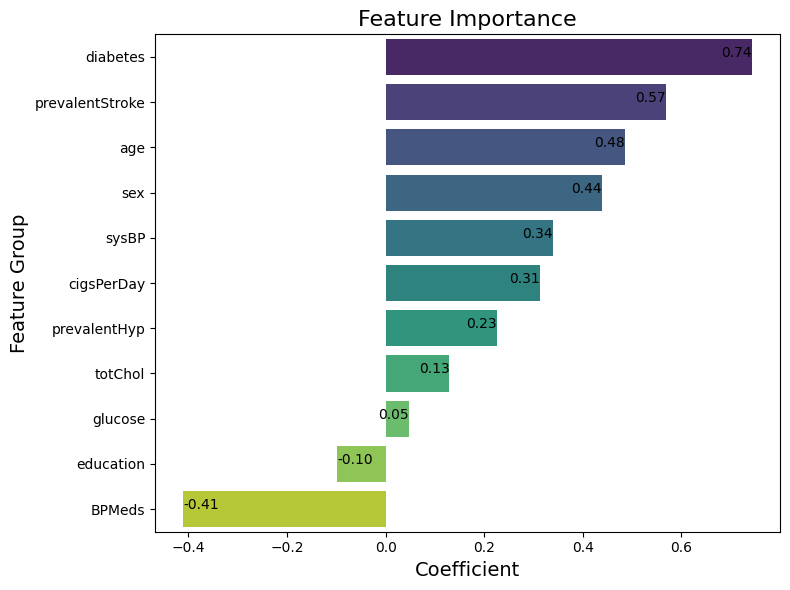

Feature,Coefficient,Odds Ratio,Interpretation
diabetes,0.740000,2.100000,Having diabetes increases the odds of CHD by 2.10 times
prevalentStroke,0.570000,1.760000,Having prevalentStroke increases the odds of CHD by 1.76 times
age,0.480000,1.620000,An increase in age increases the odds of CHD by 1.62 times
sex,0.440000,1.550000,Being male increases the odds of CHD by 1.55 times
sysBP,0.340000,1.400000,An increase in sysBP increases the odds of CHD by 1.40 times
cigsPerDay,0.310000,1.370000,An increase in cigsPerDay increases the odds of CHD by 1.37 times
prevalentHyp,0.230000,1.250000,Having prevalentHyp increases the odds of CHD by 1.25 times
totChol,0.130000,1.140000,An increase in totChol increases the odds of CHD by 1.14 times
glucose,0.050000,1.050000,An increase in glucose increases the odds of CHD by 1.05 times
education,-0.100000,0.910000,Having more education decreases the odds of CHD by 0.91 times


In [23]:
num_features = continuous_cols
cat_features = (
    my_pipeline.named_steps["preprocessor"]
    .transformers_[1][1]
    .named_steps["onehot"]
    .get_feature_names_out(categorical_cols)
)

feature_names = np.concatenate([num_features, cat_features])

coefficients = model.coef_[0]

coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})

coef_df["Feature Group"] = coef_df["Feature"].str.split("_").str[0]
coef_df_grouped = coef_df.groupby("Feature Group", as_index=False).agg(
    {"Coefficient": "sum"}
)

coef_df_grouped["Odds Ratio"] = np.exp(coef_df_grouped["Coefficient"])

coef_df_grouped = coef_df_grouped.sort_values(by="Coefficient", ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x="Coefficient", y="Feature Group", data=coef_df_grouped, palette="viridis")
plt.title("Feature Importance", fontsize=16)
plt.xlabel("Coefficient", fontsize=14)
plt.ylabel("Feature Group", fontsize=14)

for index, value in enumerate(coef_df_grouped["Coefficient"]):
    plt.text(
        value, index, f"{value:.2f}", color="black", ha="left" if value < 0 else "right"
    )

plt.tight_layout()
plt.show()


def interpret_row(row):
    if row["Feature Group"] == "sex":
        if row["Coefficient"] > 0:
            return (
                f"Being male increases the odds of CHD by {row['Odds Ratio']:.2f} times"
            )
        else:
            return f"Being female decreases the odds of CHD by {row['Odds Ratio']:.2f} times"
    elif row["Feature Group"] in categorical_cols:
        if row["Coefficient"] > 0:
            return f"Having {row['Feature Group']} increases the odds of CHD by {row['Odds Ratio']:.2f} times"
        else:
            return f"Having more {row['Feature Group']} decreases the odds of CHD by {row['Odds Ratio']:.2f} times"
    else:
        if row["Coefficient"] > 0:
            return f"An increase in {row['Feature Group']} increases the odds of CHD by {row['Odds Ratio']:.2f} times"
        else:
            return f"An increase in {row['Feature Group']} decreases the odds of CHD by {row['Odds Ratio']:.2f} times"


coef_df_grouped["Interpretation"] = coef_df_grouped.apply(interpret_row, axis=1)

coef_df_grouped["Coefficient"] = coef_df_grouped["Coefficient"].round(2)
coef_df_grouped["Odds Ratio"] = coef_df_grouped["Odds Ratio"].round(2)

interpretation_table = coef_df_grouped[
    ["Feature Group", "Coefficient", "Odds Ratio", "Interpretation"]
]
interpretation_table.columns = [
    "Feature",
    "Coefficient",
    "Odds Ratio",
    "Interpretation",
]

display(
    interpretation_table.style.set_table_styles(
        [
            {
                "selector": "thead th",
                "props": [
                    ("background-color", "#d6d6d6"),
                    ("color", "black"),
                    ("font-weight", "bold"),
                ],
            }
        ],
        overwrite=False,
    )
    .set_properties(**{"text-align": "left"})
    .hide(axis="index")
)

##### Observations:
- In a logistic regression model, coefficients represent the relationship between each feature and the log-odds of the target (in this case, CHD risk). 
- A positive coefficient indicates that as the value of the feature increases, the log-odds of the target also increase - the feature is associated with a higher risk of CHD.
- A negative coefficient indicates that as the value of the feature increases, the log-odds of the target decrease - the feature is associated with a lower risk of CHD.
- The magnitude of coefficients indicates the strength of the relationship between the feature and the target variable: larger coefficients have a greater influence on the prediction.
- If coefficient of binary features is positive, the outcome becomes more likely; if negative, it is less likely (e.g., **sex (Female = 0, Male = 1)** - a positive coefficient indicates that being male is associated with a higher risk of CHD compared to being female); **prevalent stroke (No = 0, Yes = 1)** - a positive coefficient means that patients who have had a stroke (compared to those who did not have) are at a higher risk for CHD.
- Odds ratio indicates how much the odds of the target increase or decrease for a one-unit increase in a feature.

## 5. Key Insights and Recommendations

1. **Classification Report With Default Threshold**:
- **Class 0 (Non-CHD)**:
    - **Precision (0.92)**: Of all the cases predicted as Non-CHD, 92% were actually Non-CHD. The high precision indicates that the model is very accurate when it predicts that a patient does not have CHD.
    - **Recall (0.71)**: The model correctly identified 71% of all actual Non-CHD cases, which means that 29% of the Non-CHD cases were misclassified as CHD.
    - **F1-Score (0.80)**: The harmonic mean of precision and recall. A high F1-score indicates a good balance between precision and recall for Non-CHD cases.
- **Class 1 (CHD)**:
    - **Precision (0.28)**: Of all cases predicted as CHD, only 28% were actually CHD, which indicates a high number of false positives (Non-CHD cases predicted as CHD).
    - **Recall (0.65)**: The model correctly identified 65% of all actual CHD cases, missing 35% of CHD cases.
    - **F1-Score (0.40)**: The F1-score here is relatively low, indicating a poor balance between precision and recall for CHD cases.
    - **Overall Accuracy (0.70)**: The model correctly predicted the class in 70% of all cases.
**With Default Threshold**, the model is more conservative, favoring precision over recall, particularly in the Non-CHD class; it is better at ruling out CHD (high precision) but misses more true CHD cases (lower recall).
2. **Classification Report With Optimal Threshold**:
- **Class 0 (Non-CHD)**:
    - **Precision (0.93)**: Slightly increased from 0.92 to 0.93, indicating even fewer false positives for the Non-CHD class.
    - **Recall (0.69)**: Decreased from 0.71 to 0.69, meaning the model missed more Non-CHD cases, increasing the number of false negatives.
    - **F1-Score (0.79)**: Decreased from 0.80 to 0.79, reflecting a slight decline in the overall performance for the Non-CHD class after adjusting the threshold.
- **Class 1 (CHD)**:
    - **Precision (0.29)**: Slightly increased from 0.28 to 0.29.
    - **Recall (0.71)**: Increased from 0.65 to 0.71, meaning that the model correctly identified more CHD cases, reducing the number of false negatives.
    - **F1-Score (0.41)**: Grew from 0.40 to 0.41, showing a slight improvement in the balance between precision and recall for CHD cases.
    - **Overall Accuracy (0.69)**: Decreased from 0.70 to 0.69: while the threshold adjustment improved precision and recall for CHD, it slightly worsened overall accuracy.
**With Optimal Threshold**, the model better detects CHD cases, which might be preferable in areas like health where missing a CHD case has serious consequences, even if it means accepting more false positives.

3. **ROC-AUC** (Receiver Operating Characteristic - Area Under Curve measures the model’s ability to distinguish between positive and negative classes for all possible choices of thresholds). This model has a 72.06% chance of correctly distinguishing between a patient with and without CHD. 
    - **The optimum position for ROC curve** is towards the top left corner where the specificity and sensitivity are at optimum levels.
    - **AUC** quantifies model classification accuracy: the higher the area, the greater the disparity between true and false positives, and the stronger the model in classifying members of the training dataset. An area of 0.5 corresponds to a model that performs no better than random classification and a good classifier stays as far away from that as possible. The closer the AUC to 1 the better.

4. **Confusion Matrix**: **with the default threshold** shows that the model correctly classifies 410 out of 576 negative cases and 66 out of 102 positive cases. However, it misclassifies 166 negative cases as positive and 36 positive cases as negative.
After applying the **optimal threshold**, the model correctly classifies 398 out of 576 negative cases and 72 out of 102 positive cases. However, the number of false positives increased to 178, and false negatives decreased to 30.

5. **Optimal Threshold**: By default, the logistic regression threshold is 0.5, but adjusting it to 0.4833 should improve the balance between precision and recall and maximize the model's performance. In this model, the use of an optimal threshold slightly improved recall and precision. In a healthcare setting, recall might be prioritized over precision to ensure that most CHD cases are identified, even resulting in more false positives. This approach could be particularly important in preventive screenings, where the cost of missing a true positive is higher than the cost of follow-up tests for false positives. 

6. **Feature Importance**
    - **Diabetes**: Having diabetes is the most significant factor, increasing the odds of CHD by 2.11 times. This suggests that diabetes management should be a key focus in preventing CHD.
    - **Prevalent Stroke**: Individuals with a history of stroke are 1.76 times more likely to develop CHD and they need close monitoring for CHD risk factors.
    - **Age**: As age increases, the risk of CHD increases by 1.62 times. This is consistent with the well-known association between aging and cardiovascular diseases.
    - **Sex**: Males have a 1.55 times higher risk of CHD compared to females, which aligns with epidemiological data that males generally have a higher risk of heart disease.
    - **Systolic Blood Pressure**: Higher systolic blood pressure increases CHD risk by 1.40 times, therefore, blood pressure control should be among priorities in healthcare.
    - **Cigarettes Per Day**: Smoking increases the risk of CHD by 1.37 times, highlighting the importance of stopping smoking programs.
    - **Prevalent Hypertension**: Individuals with previous hypertension are 1.25 times more likely to develop CHD and they need close monitoring for CHD risk factors.
    - **Total Cholesterol**: Higher cholesterol levels slightly increase the risk of CHD by 1.14 times, which suggests that lipid-lowering strategies could be beneficial.
    - **Glucose**: Elevated glucose levels have a modest impact on CHD risk (1.05 times increase), suggesting the importance of blood sugar control.
    - **Education**: Potentially higher levels of education are associated with a reduced risk of CHD by 0.91 times, which may reflect the role of education in promoting healthier lifestyles.
    - **Blood Pressure Medications**: The use of blood pressure medications is associated with a reduced risk of CHD by 0.66 times, highlighting the effectiveness of medication in reducing cardiovascular risk.
7. **Recommendations**
- **Focus on High-Risk Groups**: Given that diabetes, stroke history, age, and being male are strong predictors of CHD, targeted interventions should be directed at these high-risk groups. Also, stopping of smoking, blood pressure control, and cholesterol management should be encouraged as these factors significantly impact CHD risk.
- **Increase Education and Awareness**: Increasing public awareness about the importance of education in adopting healthier lifestyles could indirectly reduce CHD risk.
- **Imbalanced Precision Across Classes**: The significant difference in precision between the negative and positive classes (92% vs. 28% at default and 93% vs. 29% at optimal threshold) suggests that the model is better at predicting the absence of CHD than its presence. This imbalance could lead to overconfidence in negative predictions and underdiagnosis in positive cases. To address this, augmenting the dataset with more positive cases (if possible) or employing techniques such as SMOTE (Synthetic Minority Over-sampling Technique) to balance the class distribution could be considered. 
8. **Model Weaknesses**: The recall and F1-score indicate that the model has a notable number of false negatives, which could be problematic in a health setting where missing a positive case is risky. The imbalance between precision and recall, particularly the low precision for the Non-CHD class, suggests that the model is better at identifying CHD than ruling it out in Non-CHD cases.
9. **Next Steps**: Further tuning of the model could be considered, like reviewing feature selection or adjusting the threshold. Additionally, experimenting with other models might improve recall without sacrificing precision.